In [1]:
import pandas as pd

In [57]:
!pip install xgboost

Mean Squared Error (MSE): 98.02098783517269
Root Mean Squared Error (RMSE): 9.900554925617689


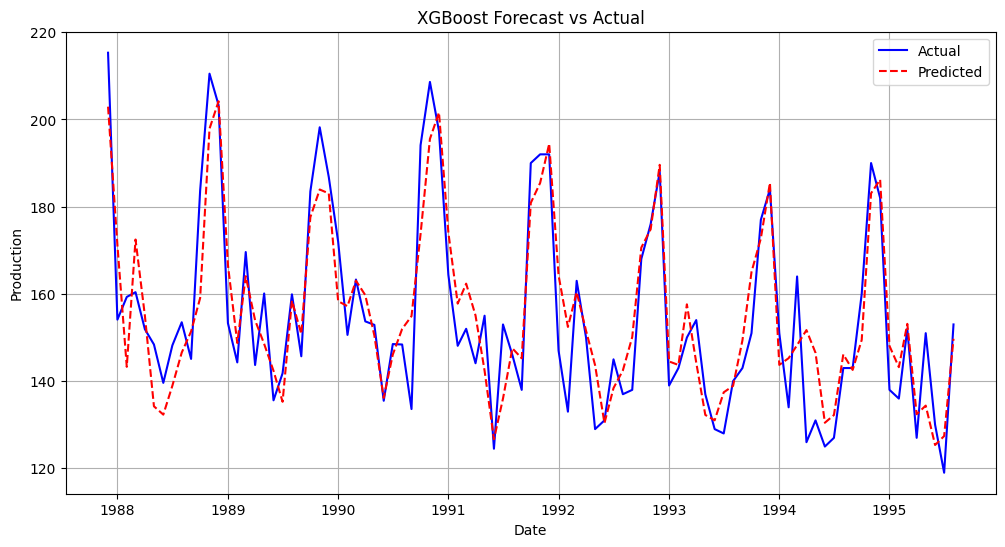

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_csv('beer_production.csv', parse_dates=['Month'], index_col='Month')
data.columns = ['Production']

# Create time series features
def create_time_series_features(data):
    # Lagged values
    for i in range(1, 13):  # Create lags for the past 12 months
        data[f'lag_{i}'] = data['Production'].shift(i)

    # Rolling statistics
    data['rolling_mean'] = data['Production'].rolling(window=12).mean()  # 12-month rolling mean
    data['rolling_std'] = data['Production'].rolling(window=12).std()  # 12-month rolling std

    # Date-based features
    data['month'] = data.index.month  # Extract month (1-12)
    data['quarter'] = data.index.quarter  # Extract quarter (1-4)

    # Trend (index as a linear trend)
    data['trend'] = np.arange(len(data))

    # Drop missing values created by lags and rolling stats
    data = data.dropna()
    return data

# Add features to the dataset
data = create_time_series_features(data)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Prepare features and target
X_train = train.drop(columns=['Production'])
y_train = train['Production']
X_test = test.drop(columns=['Production'])
y_test = test['Production']

# Initialize and fit XGBoost model
model = XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Maximum depth of a tree
    random_state=42,
    objective='reg:squarederror',  # Regression task
    n_jobs=-1  # Use all available CPU cores for faster processing
)

model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title('XGBoost Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

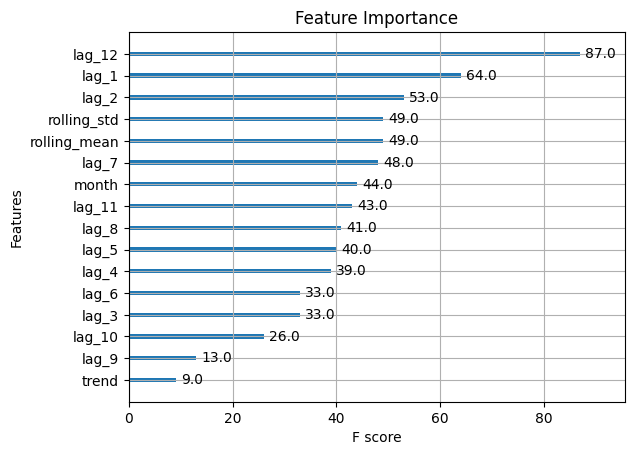

In [59]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(model)
plt.title('Feature Importance')
plt.show()

### **Feature Importance Analysis**

1. **Most Important**: `lag_12` (70.36%) — production from the same month last year is highly influential.
2. **Other Important**: `lag_11` (9.19%), `month` (5.64%).
3. **Least Important**: `quarter` (0%) — can be removed.
4. **Rolling Stats**: `rolling_mean` (2.89%), `rolling_std` (2.05%).
5. **Trend**: Minimal impact (0.96%).



In [60]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Print best parameters and MSE
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best MSE: 109.96503405065343
